# Fundamentals of Image and Video Processing Innovative Assignment
## Submitted by:
### 18BCE088 - Jyot Makadiya
### 18BCE259 - Shrey Viradiya

# Importing Libraries

In [30]:


import numpy as np
import cv2
import os 
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import convolve2d

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical



# Enviroment variables

In [31]:
path = "../input/ocular-disease-recognition-odir5k"
datafr = pd.read_csv(os.path.join(path, "full_df.csv"))
# Image size
ROW = 100
COL = 100

# Images file names
file_names = []

# Loaded data
training_images = []
flags = []

# Processed Features
grayscaled_images = []
inverted_images = []
thresholded_images = []
gray_histogram_of_images = []
RGB_histogram_of_images = []
conny_edged_images = []
laplacian_edged_images = []
x_edged_images = []
y_edged_images = []

threshold_mean = []
threshold_median = []
threshold_std_dev = []

conny_mean = []
conny_median = []
conny_std_dev = []

# Filtering Cataract & Healthy eyes from others

In [32]:
cutter = 0
division = 1 # Increase to decrease number of images to load .. faster outputing for testing
file_names.clear()
flags.clear()
for label, flag, file_name in zip(datafr["Left-Diagnostic Keywords"], datafr["C"], datafr["Left-Fundus"]):
    if(("cataract" in label) and (flag == 1)):
        file_names.append(file_name)
        flags.append(1)
    elif(("normal fundus" in label) and (flag == 0)):
        if(cutter%division == 0):
            file_names.append(file_name)
            flags.append(0)
        cutter = cutter + 1

cutter = 0
for label, flag, file_name in zip(datafr["Right-Diagnostic Keywords"], datafr["C"], datafr["Right-Fundus"]):
    if(("cataract" in label) and (flag == 1)):
        file_names.append(file_name)
        flags.append(1)
    elif(("normal fundus" in label) and (flag == 0)):
        if(cutter%division == 0):
            file_names.append(file_name)
            flags.append(0)
        cutter = cutter + 1

print("Data Length =",len(file_names), "files", len(flags), "flags")

Data Length = 6162 files 6162 flags


In [33]:
dt = list(zip(file_names, flags))
dt.sort(key = lambda x: x[1])
dt = dt[:594] + dt[-594:]
file_names.clear()
flags.clear()
for filename, flag in dt:
    file_names.append(filename)
    flags.append(flag)
    
print(len(file_names), len(flags))

1188 1188


# Cataract Ratio

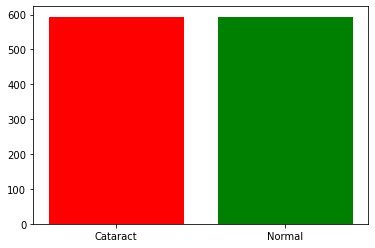

In [34]:
plt.bar([0,1], [len([i for i in flags if i == 1]), len([i for i in flags if i == 0])], color = ['r', 'g'])
plt.xticks([0, 1], ['Cataract', 'Normal'])
plt.show()

# Loading Images

In [35]:
# %%time
training_images.clear()
labels = []
for idx, image_name in enumerate(file_names):
    image = cv2.imread(os.path.join(path,"preprocessed_images",image_name))
    try:
        image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (ROW, COL))
        image = cv2.normalize(image, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype =cv2.CV_8U)
        training_images.append(image)
        labels.append(flags[idx])
    except:
        pass

# Images Sample

(1164, 100, 100, 3)
uint8


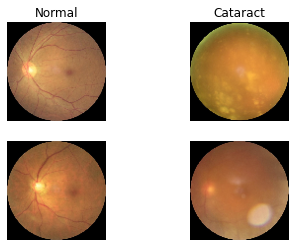

(6078, 100, 100, 3)

In [36]:
def showSamples(images, gray = False):
    figure, axes = plt.subplots(2, 2)
    axes[0, 0].title.set_text("Normal")
    axes[0, 1].title.set_text("Cataract")
    
    axes[0, 0].axis('off')
    axes[0, 1].axis('off')
    axes[1, 0].axis('off')
    axes[1, 1].axis('off')
    
    axes[0, 0].imshow(images[0],cmap='gray') if gray else axes[0, 0].imshow(images[0])
    axes[0, 1].imshow(images[1],cmap='gray') if gray else axes[0, 1].imshow(images[1])
    axes[1, 0].imshow(images[2],cmap='gray') if gray else axes[1, 0].imshow(images[2])
    axes[1, 1].imshow(images[3],cmap='gray') if gray else axes[1, 1].imshow(images[3])
    plt.show()

print(np.array(training_images).shape)
print(training_images[100].dtype)
showSamples([training_images[0], training_images[-1], training_images[12], training_images[-17]])

(6078, 100, 100, 3)

# Feature Extraction

## F1 Grayscale

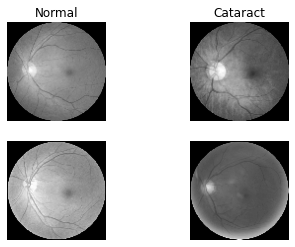

In [37]:
def rgb2gray(rgb):
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray.astype(np.int16)



grayscaled_images.clear()
for idx, image in enumerate(training_images):
    gray_image = rgb2gray(image)
    grayscaled_images.append(gray_image)

showSamples(grayscaled_images, True)



## F2 Threshold

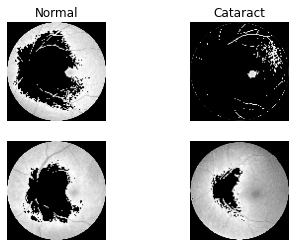

In [38]:
def THRESH_TOZERO_INV(gray):
    gray[gray > 127] = 0
    return gray

showSamples([THRESH_TOZERO_INV(grayscaled_images[0]),
             THRESH_TOZERO_INV(grayscaled_images[2]),
             THRESH_TOZERO_INV(grayscaled_images[12]),
             THRESH_TOZERO_INV(grayscaled_images[17])]
            , True)

## F4 Grayscale Histogram

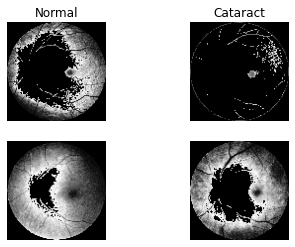

In [39]:
def equalizeHist(image):
    flat = image.flatten()
    hist,bins = np.histogram(flat,256,[0,256])
    cdf = hist.cumsum()
    cdf_m = (cdf - cdf.min())*255/(cdf.max()-cdf.min())
    cdf_m = cdf_m.astype('uint8')
    img_new = cdf_m[flat]
    img_new = np.reshape(img_new, image.shape)
    return img_new


showSamples([equalizeHist(grayscaled_images[0]),
             equalizeHist(grayscaled_images[2]),
             equalizeHist(grayscaled_images[17]),
             equalizeHist(grayscaled_images[12])]
            , True)

## F5 RGB Histogram

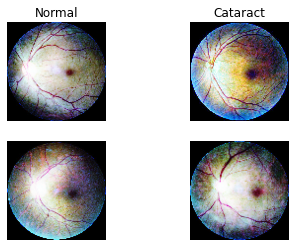

In [40]:
def RGB_histogram(image):
    return np.dstack((equalizeHist(image[:,:,0]), equalizeHist(image[:,:,1]), equalizeHist(image[:,:,2])))

showSamples([RGB_histogram(training_images[0]),
             RGB_histogram(training_images[2]),
             RGB_histogram(training_images[17]),
             RGB_histogram(training_images[12])]
            , False)

## F3 Conny Edge detection

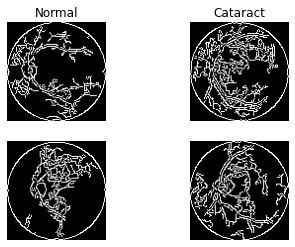

In [41]:
def CannyEdge(image):
    return cv2.Canny(image,30,200)

showSamples([CannyEdge(training_images[0]),
             CannyEdge(training_images[2]),
             CannyEdge(training_images[17]),
             CannyEdge(training_images[12])]
            , True)

## F6 X Edges

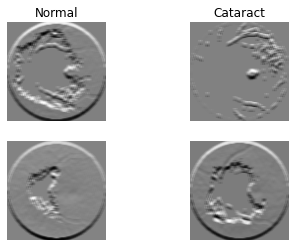

In [42]:
def SobelX(image):
    filter = np.array([[2,2,4,2,2], [1,1,2,1,1], [0,0,0,0,0],[-1,-1,-2,-1,-1],[-2,-2,-4,-2,-2]])
    return convolve2d(image, filter, mode="same")

def SobelY(image):
    filter = np.array([[2,2,4,2,2], [1,1,2,1,1], [0,0,0,0,0],[-1,-1,-2,-1,-1],[-2,-2,-4,-2,-2]]).T
    return convolve2d(image, filter, mode="same")


showSamples([SobelX(grayscaled_images[0]),
             SobelX(grayscaled_images[2]),
             SobelX(grayscaled_images[17]),
             SobelX(grayscaled_images[12])]
            , True)

## F7 Y Edges

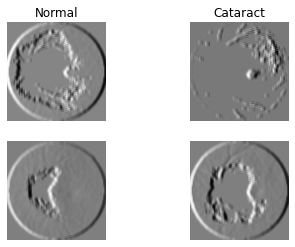

In [43]:


showSamples([SobelY(grayscaled_images[0]),
             SobelY(grayscaled_images[2]),
             SobelY(grayscaled_images[17]),
             SobelY(grayscaled_images[12])]
            , True)



## F8 Laplacian Edges

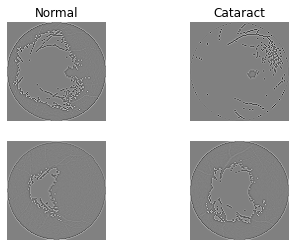

In [44]:
def Laplacian(image):
    return cv2.Laplacian(image, cv2.CV_64F)

showSamples([Laplacian(grayscaled_images[0]),
             Laplacian(grayscaled_images[2]),
             Laplacian(grayscaled_images[17]),
             Laplacian(grayscaled_images[12])]
            , True)

## F9 Mean, Median, Mode, Standard Deviation of ***Threshold***

## F9 Mean, Median, Mode, Standard Deviation of ***Conny***

In [45]:
del grayscaled_images

# Formating the data for Machine Learning

In [46]:
%%time
data = []

for image in training_images:
    gray = rgb2gray(image)
    data.append(
        np.dstack(
            (image,
             gray,
             equalizeHist(gray),
             RGB_histogram(image),
             CannyEdge(image),
             Laplacian(gray)
             )
        )
    )

CPU times: user 4.2 s, sys: 1.17 s, total: 5.37 s
Wall time: 3.16 s


In [48]:
image_train, image_test, flag_train, flag_test = train_test_split(data, np.asarray(labels), test_size=0.15, random_state=42)

# Building, Training & Testing the NN Model

In [49]:
from sklearn.preprocessing import MultiLabelBinarizer
from tqdm.notebook import tqdm
from tensorflow import keras
import matplotlib.pyplot as plt
import tensorflow_addons as tfa
import tensorflow as tf
import pandas as pd
import numpy as np

seed = 1200
tf.random.set_seed(seed)

orig_model = tf.keras.applications.ResNet50(include_top=False, weights='imagenet', input_shape = (100,100,3))
dense_input = tf.keras.layers.Input(shape=(100, 100, 10))
dense_filter = tf.keras.layers.Conv2D(3, 3, padding='same')(dense_input)
output = orig_model(dense_filter)
x = tf.keras.layers.Flatten()(output)
x = tf.keras.layers.Dense(128, activation='relu')(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
dense_out = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(dense_input, dense_out)

# Freezing the weights
for layer in model.layers[3:-3]:
    layer.trainable=False
    
model.summary()


94773248/94765736 [==============================] - 1s 0us/step
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100, 100, 10)]    0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 3)       273       
_________________________________________________________________
resnet50 (Functional)        (None, 4, 4, 2048)        23587712  
_________________________________________________________________
flatten (Flatten)            (None, 32768)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               4194432   
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_______________________________________________________

In [50]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.Adam(lr=1e-4), 
              metrics= ['accuracy'])


In [52]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
history = model.fit(np.array(image_train),flag_train,validation_data = (np.array(image_test),flag_test), epochs=10, batch_size = 64,callbacks=[ReduceLROnPlateau(monitor='val_loss', factor=0.3,patience=3, min_lr=0.000001)])

Epoch 1/10
16/16 [==============================] - 3s 204ms/step - loss: 0.3675 - accuracy: 0.8423 - val_loss: 0.5417 - val_accuracy: 0.7943
Epoch 2/10
16/16 [==============================] - 2s 110ms/step - loss: 0.0307 - accuracy: 0.9929 - val_loss: 0.3145 - val_accuracy: 0.8686
Epoch 3/10
16/16 [==============================] - 2s 108ms/step - loss: 0.0054 - accuracy: 0.9990 - val_loss: 0.2524 - val_accuracy: 0.9200
Epoch 4/10
16/16 [==============================] - 2s 111ms/step - loss: 0.0042 - accuracy: 0.9990 - val_loss: 0.2573 - val_accuracy: 0.9200
Epoch 5/10
16/16 [==============================] - 2s 110ms/step - loss: 0.0034 - accuracy: 0.9990 - val_loss: 0.2002 - val_accuracy: 0.9429
Epoch 6/10
16/16 [==============================] - 2s 108ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.2080 - val_accuracy: 0.9371
Epoch 7/10
16/16 [==============================] - 2s 108ms/step - loss: 4.9148e-04 - accuracy: 1.0000 - val_loss: 0.2147 - val_accuracy: 0.9486
Ep